In [ ]:
!pip install NearPy

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
  Created wheel for bitarray: filename=bitarray-1.6.1-cp36-cp36m-linux_x86_64.whl size=111971 sha256=33cb3bffabb889dd1188808711b2e50f9f04dcab6fe705e693c9845535cff62e
  Stored in directory: /root/.cache/pip/wheels/9a/aa/60/bc6e8aa0406e979931b75cfec65be58d051d2122d05efb4c65
Successfully built bitarray


In [ ]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
import numpy as np
import time
from keras.regularizers import l2
import util
from sklearn.metrics import pairwise_distances
import tensorflow as tf

None


In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

num_images = 50000

####
X_train = X_train[:num_images]
Y_train = Y_train[:num_images]
####

num_classes, smtk = 10, 0
Y_train_nocat = Y_train
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
batch_size = 32
subset_size = .6
epochs = 15
reg = 1e-4

In [ ]:
train_loss, test_loss = np.zeros((epochs, 1)), np.zeros((epochs, 1))
train_acc, test_acc = np.zeros((epochs, 1)), np.zeros((epochs, 1))
train_time = np.zeros((epochs, 1))
grd_time, sim_time, pred_time = np.zeros((epochs, 1)), np.zeros((epochs, 1)), np.zeros((epochs, 1))
not_selected = np.zeros((epochs, 1))
times_selected = np.zeros((len(X_train), 1))
best_acc = 0

In [ ]:
model = tf.keras.models.Sequential([
                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
X_subset = X_train
Y_subset = Y_train
W_subset = np.ones(len(X_subset))
ordering_time,similarity_time, pre_time = 0, 0, 0
loss_vec, acc_vec, time_vec = [], [], []

for epoch in range(0, epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    num_batches = int(np.ceil(X_subset.shape[0] / float(batch_size)))

    for index in range(num_batches):
        X_batch = X_subset[index * batch_size:(index + 1) * batch_size]
        Y_batch = Y_subset[index * batch_size:(index + 1) * batch_size]
        W_batch = W_subset[index * batch_size:(index + 1) * batch_size]

        start = time.time()
        history = model.train_on_batch(X_batch, Y_batch, sample_weight=W_batch)
        train_time[epoch] += time.time() - start
    
    start = time.time()
    _logits = model.predict(X_train)
    pre_time = time.time() - start
    features = _logits - Y_train

    indices, W_subset, _, _, ordering_time, similarity_time = util.get_orders_and_weights(int(
        subset_size * len(X_train)), features, 'euclidean', smtk, 0, False, Y_train_nocat)

    W_subset = W_subset / np.sum(W_subset) * len(W_subset)

    grd_time[epoch], sim_time[epoch], pred_time[epoch] = ordering_time, similarity_time, pre_time
    times_selected[indices] += 1
    not_selected[epoch] = np.sum(times_selected == 0) / len(times_selected) * 100

    X_subset = X_train[indices, :]
    Y_subset = Y_train[indices]

    start = time.time()
    score = model.evaluate(X_test, Y_test, verbose=1)
    eval_time = time.time()-start

    start = time.time()
    score_loss = model.evaluate(X_train, Y_train, verbose=1)
    print(f'eval time on training: {time.time()-start}')

    test_loss[epoch], test_acc[epoch] = score[0], score[1]
    train_loss[epoch], train_acc[epoch] = score_loss[0], score_loss[1]
    best_acc = max(test_acc[epoch], best_acc)

    print(f'subset_size: {subset_size}, epoch: {epoch}, test_acc: {test_acc[epoch]}, '
              f'loss: {train_loss[epoch]}, best_prec1_gb: {best_acc}, not selected %:{not_selected[epoch]}')

Epoch 0/14
not equal_num
0
[   29    30    35 ... 49941 49992 49994]
5000
Hello
1
[    4     5    32 ... 49993 49998 49999]
5000
Hello
2
[    6    13    18 ... 49987 49991 49995]
5000
Hello
3
[    9    17    21 ... 49979 49982 49983]
5000
Hello
4
[    3    10    20 ... 49981 49984 49990]
5000
Hello
5
[   27    40    51 ... 49964 49980 49988]
5000
Hello
6
[    0    19    22 ... 49962 49966 49996]
5000
Hello
7
[    7    11    12 ... 49965 49978 49986]
5000
Hello
8
[    8    62    69 ... 49968 49976 49985]
5000
Hello
9
[    1     2    14 ... 49963 49971 49997]
5000
Hello
Selecting with ratios [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Class proportions [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1994 - accuracy: 0.5722
eval time on training: 19.15191960334778
subset_size: 0.6, epoch: 0, test_acc: [0.55900002], loss: [1.19944406], best_prec1_gb: [0.55900002], not selected %:[40.]
Epoch 1/14
not equal_num
0
[   29    30    35 ... 49941

[array([0.55900002]), array([0.60390002]), array([0.6372]), array([0.62739998]), array([0.67400002]), array([0.66570002]), array([0.67919999]), array([0.69279999]), array([0.69050002]), array([0.68550003]), array([0.69590002]), array([0.67290002]), array([0.70300001]), array([0.69330001]), array([0.7062])]


(0.0, 1.0)

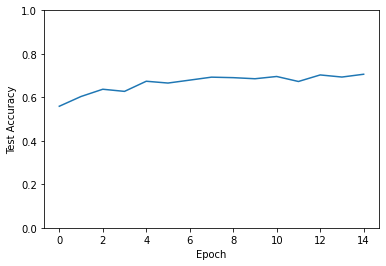

In [ ]:
import matplotlib.pyplot as plt
validation_acc = []
for epoch in range(test_acc.shape[0]):
    validation_acc.append(test_acc[epoch])

print(validation_acc)

plt.plot(validation_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.ylim([0.0, 1])

In [ ]:
not_selected = [i for i in range(20000) if i not in indices]

In [ ]:
np.save("indices_craig_60.npy", indices)

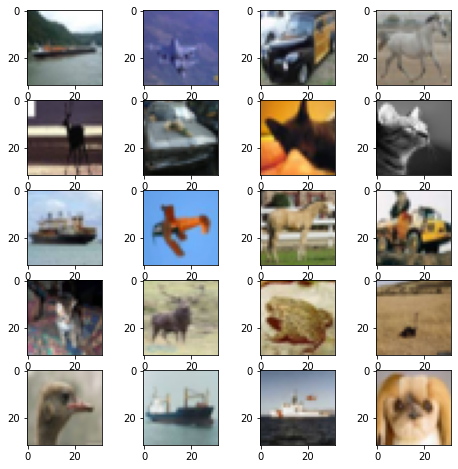

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    not_selected_img = np.random.randint(len(not_selected))
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[not_selected_img])
plt.show()

In [ ]:
indices_agg = np.load('indices_agg.npy')

In [ ]:
times_selected_reshaped = times_selected.reshape((num_images,))
indices_craig = np.argpartition(times_selected_reshaped, -int(
        subset_size * len(X_train)))[-int(
        subset_size * len(X_train)):]

In [ ]:
np.save("indices_craig_all", indices_craig)

In [ ]:
common_elements = np.intersect1d(indices_craig, indices_agg)
print(len(common_elements)/(subset_size * len(X_train)))

0.7900625


In [ ]:
X_subset_craig = X_train[indices_craig]
X_subset_craig_labels = Y_train[indices_craig]

model_subset_craig = tf.keras.models.Sequential([
                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(10, activation='softmax')])

model_subset_craig.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_subset = model_subset_craig.fit(X_subset_craig, X_subset_craig_labels, epochs=20, 
                    validation_data=(X_test, Y_test), verbose=False)

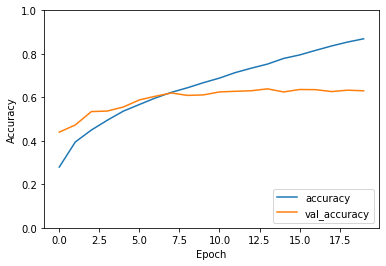

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_subset.history['accuracy'], label='accuracy')
plt.plot(history_subset.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [ ]:
X_subset_agg = X_train[indices_agg]
X_subset_agg_labels = Y_train[indices_agg]

model_subset_agg = tf.keras.models.Sequential([
                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(10, activation='softmax')])

model_subset_agg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_subset_agg = model_subset_agg.fit(X_subset_craig, X_subset_craig_labels, epochs=20, 
                    validation_data=(X_test, Y_test), verbose=False)

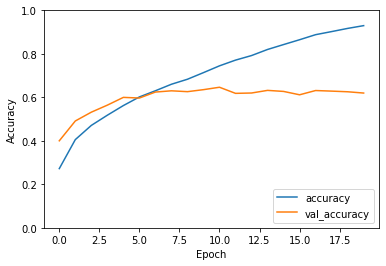

In [ ]:
plt.plot(history_subset_agg.history['accuracy'], label='accuracy')
plt.plot(history_subset_agg.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [ ]:
np